<p style="font-size:32px; font-weight: bolder; text-align: center"> Atom-centered density correlation representations </p>
<p style="text-align: center"><i> authored by: <a href="mailto:michele.ceriotti@gmail.com"> Michele Ceriotti </a></i></p>

This notebook demonstrates some of the concepts discussed in the second lecture in the "Introduction to Atomic-Scale Machine Learning" mini-course. 
It demonstrates the construction of descriptors of an atom-centered environment based on an expansion of the neighbor density in radial functions 
and spherical harmonics, and how these can be combined to build higher-order invariant and equivariant descriptors. 

The notebook contains .....

1. [Molecular motif recognition: detection of solid nuclei in supercooled irons](#iron-motifs)
2. [Linear methods: structure-property maps for azaphenacene](#azaphenacene)

In [104]:
%matplotlib inline
import numpy as np
import ase, ase.io
import matplotlib as mpl
import matplotlib.pyplot as plt 
import itertools

import chemiscope

import rascaline
import sphericart
import metatensor as mt
from metatensor import mean_over_samples, Labels

from skmatter.metrics import global_reconstruction_error, local_reconstruction_error

<a id="water-descriptors"> </a>

# Density-correlation descriptors for water

This dataset contains a collection of configurations for a single water molecule. The coinfigurations are generated by distorting an equilibrium configuration along the bending mode, and the asymmetric stretching coordinate. Each frame contains also the energy and dipole moment, computed with the Partridge-Schwenke monomer potential ([Partridge, Schwenke, J. Chem. Phys. (1997)](http://doi.org/10.1063/1.473987)). 

## Load and prepare the dataset

Just a visualization of the data, and processing it in a form that is suitable for modeling

In [21]:
h2o_frames = ase.io.read("data/water_energy-dipole.xyz", ":")

h2o_energy = np.zeros(len(h2o_frames))
h2o_dipole = np.zeros((len(h2o_frames),3))
h2o_force = np.zeros((len(h2o_frames),3,3))
for fi, f in enumerate(h2o_frames):
    h2o_energy[fi] = f.info['energy']
    h2o_dipole[fi] = f.info['dipole']
    h2o_force[fi] = f.arrays['force']

In [19]:
dipole_arrows = chemiscope.ase_vectors_to_arrows(h2o_frames, "dipole", scale=4, head_length_scale=3);
dipole_arrows["parameters"]["global"].update({ "color": 0x60A0FF })
cs = chemiscope.show(h2o_frames, properties = chemiscope.extract_properties(h2o_frames),
        shapes={ "dipole" : dipole_arrows},
        settings={
            'map' : { 'x':{'property' : "HOH"},  'y':{'property' : "OH1"}, 'color' : {'property' : 'energy'} },
            'structure': [{'axes': 'off','keepOrientation': True, 'shape': ['dipole']}]
        })

if chemiscope.jupyter._is_running_in_notebook():
    from IPython.display import display
    display(cs)

<ChemiscopeWidget(meta={'name': ' '}, settings={'map': {'x': {'property': 'HOH'}, 'y': {'property': 'OH1'}, 'c…

## Compute the density expansion

We now move on to discuss how to describe an atomic environment using expansion coefficients of the atomic density. 
In short, the idea is to start describing a molecule $A$ in terms of localized functions (e.g. Gaussians) centered on each atom $i$, "labelled" by their chemical nature $a$

$$
\langle a \mathbf{x} | A; \rho\rangle = \sum_{i \in A} \delta_{a a_i} \langle \mathbf{x} | \mathbf{r}_i \rangle.
$$

We use  the notation $\langle \mathbf{x} | \mathbf{r}_i \rangle = g(\mathbf{x}-\mathbf{r}_i)$ to emphasize how the full structure is built as a sum of terms that describe individual atoms, and how this description can be implemented in any continuous or discrete basis. 
In general terms, in analogy with the Dirac notation used to describe a quantum state, we use the notation $\langle q | A\rangle$ to indicate a descriptor $| A\rangle$ for an entity $A$, discretized in a basis that is enumerated by the index $q$. 
See Section 3.1 of [this review](https://doi.org/10.1021/acs.chemrev.1c00021) for a gentler introduction. 

This density is then symmetrized with respect to translations (reflecting the fact that atomic properties are invariant to rigid translations of a molecule) which leads to expressing the structure descriptors as a sum of descriptors of _atom centered environments_ $A_i$,


$$
\langle a \mathbf{x} | A; \rho\rangle = \sum_i \langle a \mathbf{x} | \rho_i\rangle
$$

$$
\langle a \mathbf{x} | \rho_i\rangle = \sum_{j \in A_i} \delta_{a a_j} \langle \mathbf{x} | \mathbf{r}_{ji} \rangle.
$$

where the Gaussians are evaluated at the interatomic distance vectors $\mathbf{r}_{ji}=\mathbf{r}_j-\mathbf{r}_i$.

To manipulate this atom-centered density, it is more convenient to express it on a discrete basis. Guided by symmetry considerations that will become apparent, and in analogy with what is done routinely in quantum chemistry for the electron wafefunction (or density) we use a basis of radial functions $R_{nl}(x) \equiv \langle x||nl\rangle$ and spherical harmonics $Y^m_{l}(\hat{\mathbf{x}}) \equiv \langle \hat{\mathbf{x}}|lm\rangle$

$$
\langle a nlm | \rho_i\rangle = \int \mathrm{d}\mathbf{x} 
 \langle nl| x\rangle  \langle lm| \hat{\mathbf{x}} \rangle
\langle a \mathbf{x} | \rho_i\rangle  
$$

In [169]:
hypers = {
    "cutoff": 3,
    "max_radial": 4,
    "max_angular": 2,
    "atomic_gaussian_width": 0.1,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"Gto":  {"spline_accuracy": 1e-6 }},
    "center_atom_weight": 1.0
}

In [170]:
calculator = rascaline.SphericalExpansion(**hypers)

In [171]:
rhoi = calculator.compute(h2o_frames)

### Metatensor structured feature storage

`rascaline` calculators return a `metatensor.TensorMap` object, that works as a container that holds blocks of data. The pattern is reminiscent of a `dict`, but with some more structure and metadata: each block is associated with a _key_, which consists in a tuple of ints. The set of keys is a `metatensor.Labels` object, that also keeps track of the _names_ that describe each index in the key. 

The expansion keys hold the `spherical_harmonics_l` index, and two indices corresponding to the atomic number of the central atom `species_center` and of the neighbors `species_neighbor`. 

In [172]:
rhoi

TensorMap with 12 blocks
keys: spherical_harmonics_l  species_center  species_neighbor
                0                  1                1
                1                  1                1
                               ...
                1                  8                8
                2                  8                8

Each block is associated to a `metatensor.TensorBlock` object. Each block is associated with a dense tensor with a `samples` direction (enumerating the items that are described) a `properties` direction (enumerating actual properties, or descriptors) and zero or more `components` - typical examples would be the Cartesian coordinates of a vector, or the $m$ index in spherical harmonics. Each is associated with a `Labels` object that stores metadata that describe the entries.

In [173]:
rhoi.block(1)

TensorBlock
    samples (242): ['structure', 'center']
    components (3): ['spherical_harmonics_m']
    properties (4): ['n']
    gradients: None

In [52]:
print(rhoi.block(1).samples.names)
rhoi.block(1).samples.values[:10]

['structure', 'center']


LabelsValues([[0, 1],
              [0, 2],
              [1, 1],
              [1, 2],
              [2, 1],
              [2, 2],
              [3, 1],
              [3, 2],
              [4, 1],
              [4, 2]], dtype=int32)

In [56]:
print(rhoi.block(1).components[0].names)
rhoi.block(1).components[0].values

['spherical_harmonics_m']


LabelsValues([[-1],
              [ 0],
              [ 1]], dtype=int32)

In [57]:
print(rhoi.block(1).properties.names)
rhoi.block(1).properties.values[:10]

['n']


LabelsValues([[0],
              [1],
              [2],
              [3]], dtype=int32)

In [60]:
rhoi.block(0).values.shape

(242, 1, 4)

$l=0$ components are rotationally invariant, so e.g. O-centred features will be independent on the H-O-H angle. 

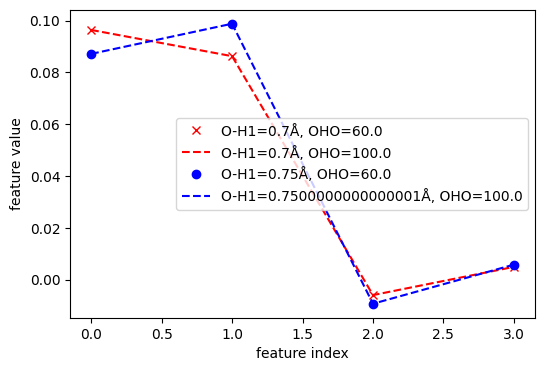

In [86]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
block = rhoi.block(spherical_harmonics_l=0, species_center=8, species_neighbor=1)
y = block.values
ax.plot(y[0,0], 'rx', label=f"O-H1={h2o_frames[0].info['OH1']}Å, OHO={h2o_frames[0].info['HOH']}")
ax.plot(y[4,0], 'r--', label=f"O-H1={h2o_frames[4].info['OH1']}Å, OHO={h2o_frames[4].info['HOH']}")
ax.plot(y[11,0], 'bo', label=f"O-H1={h2o_frames[11].info['OH1']}Å, OHO={h2o_frames[11].info['HOH']}")
ax.plot(y[15,0], 'b--', label=f"O-H1={h2o_frames[15].info['OH1']}Å, OHO={h2o_frames[15].info['HOH']}")
ax.set_xlabel('feature index')
ax.set_ylabel('feature value')
ax.legend()

$l=1$ components on the other hand are sensitive to the position of neighbors.
Overall, for a sufficiently fine-grained discretization of the density, the expansion coefficients contain full information on the position of all neighbors in 3D space. 

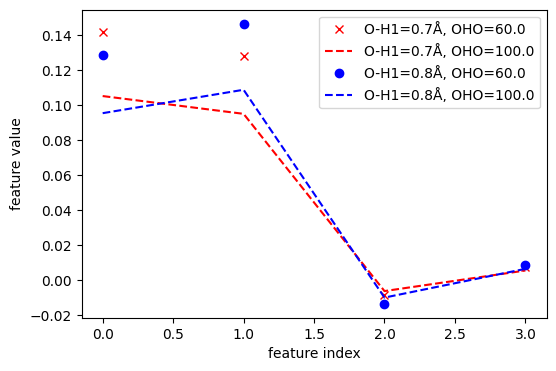

In [89]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
block = rhoi.block(spherical_harmonics_l=1, species_center=8, species_neighbor=1)
y = block.values
ax.plot(y[0,0], 'rx', label=f"O-H1={h2o_frames[0].info['OH1']:.1}Å, OHO={h2o_frames[0].info['HOH']}")
ax.plot(y[4,0], 'r--', label=f"O-H1={h2o_frames[4].info['OH1']:.1}Å, OHO={h2o_frames[4].info['HOH']}")
ax.plot(y[11,0], 'bo', label=f"O-H1={h2o_frames[11].info['OH1']:.1}Å, OHO={h2o_frames[11].info['HOH']}")
ax.plot(y[15,0], 'b--', label=f"O-H1={h2o_frames[15].info['OH1']:.1}Å, OHO={h2o_frames[15].info['HOH']}")
ax.set_xlabel('feature index')
ax.set_ylabel('feature value')
ax.legend()

## Computing information content with the GFRE

Given the possibility of having different types of descriptors, an obvious question is which choice of features provides the "best" representation of a set of structures. 
One possible answer is given by the "feature reconstruction error" metrics ([Goscinski et al., MLST (2021)](http://doi.org/10.1088/2632-2153/abdaf7)), that measures the error made by a linear model that attempts to predict features $\mathbf{X}'$ starting from an alternative featurization $\mathbf{X}$. 
Features are standardized so that complete failure in reconstructing the target representation yields a reconstruction error around 1. 

In [127]:
# we restrict the analysis to O-centered features, so there is one environment per structure. 
# we use `metatensor` utilities to consolidate l,m indices in the property block, and select exclusively 
# the blocks associated with O centers and H neighbors
block = rhoi.components_to_properties(["spherical_harmonics_m"]).keys_to_properties(["spherical_harmonics_l"]).block(species_center=8, species_neighbor=1)

First, we look how density-expansion coefficients compare with the naive descriptors based on the Cartesian coordinates of the H atoms 
relative to the O (which sits at the origin). 

Surprisingly (given that the density descriptors are computed from the positions!) the reconstruction error is larger when going from the 
positions to the coefficients than vice versa. This happens because the relationship between the two is highly non-linear: in fact, using a 
local version of the algorithm that only tries to perform a locally linear mapping shows that the two representations contain similar 
amounts of information. 

In [130]:
positions = np.array([f.positions.flatten() for f in h2o_frames])
h_positions = positions[3:] 

In [133]:
print(f"""
Global reconstruction error positions -> density coefficients: {global_reconstruction_error(positions, block.values):4f}
Global reconstruction error density coefficients -> positions: {global_reconstruction_error(block.values, positions):4f}

Local reconstruction error positions -> density coefficients: {local_reconstruction_error(positions, block.values, n_local_points=3):4f}
Local reconstruction error density coefficients -> positions: {local_reconstruction_error(block.values, positions, n_local_points=3):4f}
""")


Global reconstruction error positions -> density coefficients: 0.207318
Global reconstruction error density coefficients -> positions: 0.055457

Local reconstruction error positions -> density coefficients: 0.039321
Local reconstruction error density coefficients -> positions: 0.033520



Another useful case is looking for convergence of the density expansion. Here a linear framework is natural, even though one should keep in mind that the error is an indication of how well the discretization encodes the neighbor density information, which is redundant relative to the simple encoding of the _atomic positions_.

NB: the high->low resolution reconstruction error is _not_ zero because even the larger basis is not fully converged and the GTO basis changes with the `max_radial` parameter so the larger basis does not contain explicitly the small-basis functions

In [135]:
# update the hypers to increase the number of channels
fine_calculator = rascaline.SphericalExpansion(**{**hypers, "max_radial":12, "max_angular":8})
fine_rhoi = fine_calculator.compute(h2o_frames)
fine_block = fine_rhoi.components_to_properties(["spherical_harmonics_m"]).keys_to_properties(["spherical_harmonics_l"]).block(species_center=8, species_neighbor=1)

mid_calculator = rascaline.SphericalExpansion(**{**hypers, "max_radial":6, "max_angular":4})
mid_rhoi = mid_calculator.compute(h2o_frames)
mid_block = mid_rhoi.components_to_properties(["spherical_harmonics_m"]).keys_to_properties(["spherical_harmonics_l"]).block(species_center=8, species_neighbor=1)

In [136]:
print(f"""
Global reconstruction error high-> low resolution: {global_reconstruction_error(fine_block.values, block.values):4f}
Global reconstruction error low -> high resolution: {global_reconstruction_error(block.values, fine_block.values):4f}
Global reconstruction error mid -> high resolution: {global_reconstruction_error(mid_block.values, fine_block.values):4f}
""")


Global reconstruction error high-> low resolution: 0.001055
Global reconstruction error low -> high resolution: 0.547158
Global reconstruction error mid -> high resolution: 0.154662



# Compute the SOAP representation

The $l=0$ part of the density-expansion coefficients $\langle an00|\rho_i\rangle$ corresponds to a discretization of the pair correlation function: using a real-space basis,

$$
    \langle ax00|\rho_i\rangle \approx \sum_{j\in A_i} \delta_{a a_j} \langle x | r_{ji} \rangle 
$$

where $ \langle x | r_{ji} \rangle $ is a localized function centered on $r_{ji}$. 

In order to obtain a richer description of the atomic environment it is possible to combine several copies of $\langle a\mathbf{x} | \rho_i \rangle$, to build $\nu$-neighbors atom-centered density correlations (ACDCs). 
The formalism we use was introduced by [Willatt et al.](https://doi.org/10.1063/1.5090481), and is explained in detail, discussing its relation with the leading frameworks for atomistic machine learning, in a [review by Musil et al.](https://doi.org/10.1021/acs.chemrev.1c00021)

Essentially, the idea is that considering tensor products of the atom density provides simultaneous information on the mutual position of several neighbors

$$
\langle \mathbf{x} |  \rho_i \rangle \langle \mathbf{x}' |  \rho_i \rangle =
\sum_{jj'\in A_i}
\langle \mathbf{x} |\mathbf{r}_{ji} \rangle \langle \mathbf{x}' |\mathbf{r}_{j'i} \rangle. 
$$

The invariant part of this two-neighbor correlation function can be extracted by taking a symmetrized product of the density coefficients,
$$
\langle aa'nn'l|\overline{\rho_i^{\otimes 2}}\rangle \propto 
\sum_m  \langle anlm|\rho_i\rangle \langle a'n'lm|\rho_i\rangle
$$


`rascaline` provides the infrastructure to evaluate SOAP features using the `SoapPowerSpectrum` calculator. We can compare the results with those obtained by explicitly computing the symmetrized products. 

In [174]:
soap_calculator = rascaline.SoapPowerSpectrum(**hypers)

In [175]:
rho2i = soap_calculator.compute(h2o_frames)

The calculator returns only invariant features, with separate blocks depending on the nature of the central atom and the neighbors. 
Select the block corresponding to O-centered $\langle HHnn'(l=2)|$ features

In [176]:
rho2i

TensorMap with 6 blocks
keys: species_center  species_neighbor_1  species_neighbor_2
            1                 1                   1
            1                 1                   8
                               ...
            8                 1                   8
            8                 8                   8

In [177]:
soap_OHH = rho2i.block(species_center=8, species_neighbor_1=1, species_neighbor_2=1)
soap_OHH_l2 = soap_OHH.values[:,np.where(soap_OHH.properties["l"]==2)[0]]

... and now compute the same manually. Note the $1/\sqrt{2l+1}$ factor.

In [178]:
rhoi_OH = rhoi.blocks(species_center=8, species_neighbor=1)

In [211]:
manual_OHH_l2 = np.einsum("imn, imp-> inp", rhoi_OH[2].values, rhoi_OH[2].values).reshape(len(h2o_frames),-1)/np.sqrt(5.)

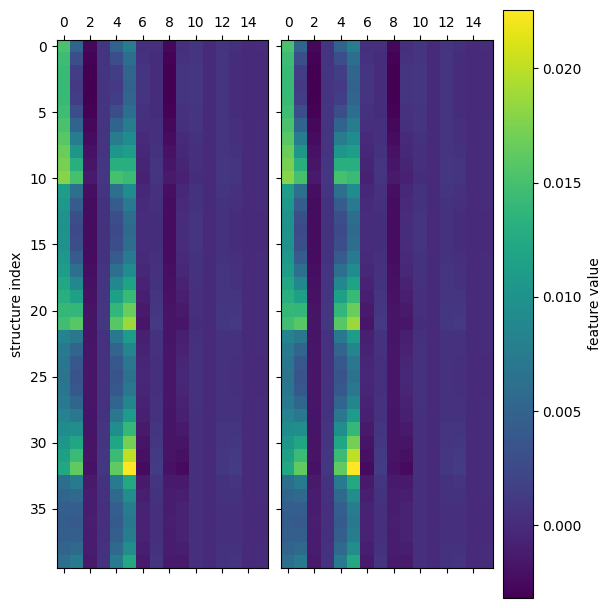

In [214]:
fig, ax = plt.subplots(1,2,figsize=(6,6), sharex=True, sharey=True, constrained_layout=True)
ax[0].matshow(soap_OHH_l2[:40])
ax[0].set_ylabel("structure index")
cbvals=ax[1].matshow(manual_OHH_l2[:40])
fig.colorbar(cbvals, label="feature value")

# Relation between density correlation features, real-space neighbor-density and atom-centered symmetry functions

The purpose of this (rather contrieved) demonstration is to show explicitly the relation between density expansion coefficients and a smooth neighbor density, and between SOAP descriptors and atom-centered symmetry functions. 
We use `SphericalBesselBasis` (the Laplacian Eigenvalues basis from [Bigi et al., JCP (2022)](http://doi.org/10.1063/5.0124363)) because it's orthonormal and makes it easier to post-process based on the utility functions in `rascaline`. 

In [292]:
import sphericart as sc

In [378]:
hypers = {
    "cutoff": 3,
    "max_radial": 6,
    "max_angular": 4,
    "atomic_gaussian_width": 0.2,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "center_atom_weight": 1.0
}

basis_functions = rascaline.utils.SphericalBesselBasis(hypers["cutoff"], hypers["max_radial"], hypers["max_angular"])

basis_integrals = rascaline.utils.SoapSpliner(
    cutoff=hypers["cutoff"],
    max_radial=hypers["max_radial"],
    max_angular=hypers["max_angular"],
    basis=basis_functions,
    density=rascaline.utils.GaussianDensity(atomic_gaussian_width=hypers["atomic_gaussian_width"])
).compute()

hypers["radial_basis"] = basis_integrals

Nice twist: we use `selected_keys` to only compute one set of element-element density coefficients, between O and H

In [379]:
calculator = rascaline.SphericalExpansion(**hypers)
rhoi_oh = calculator.compute(h2o_frames, 
                    selected_keys=mt.Labels(["spherical_harmonics_l", "species_center", "species_neighbor"],
                                           np.array([[l,8,1] for l in range(hypers["max_angular"])]  ) )
                                   )

In [380]:
def real_space_rho(x, cnlm):
    sph = sc.SphericalHarmonics(l_max=hypers["max_angular"], normalized=True).compute(x)    
    values = np.zeros(x.shape[0])
    for key, block in cnlm.items():
        l = key["spherical_harmonics_l"]
        for n in range(hypers["max_radial"]):
            rbf = basis_functions.compute(n, l, np.sqrt(np.sum(x**2,axis=1)) )
            sph_l = (sph[:,l*l:(l+1)*(l+1)]@block.values[0,:,n])
        values += rbf*sph_l
    return values        
        

In [381]:
ngrid = 40
iframe = 15
grid = np.array(list(itertools.product(np.linspace(-2,2,ngrid), np.linspace(-2,2,ngrid), [0])) 
               ).reshape(-1,3)
cnlm = mt.slice(rhoi_oh, axis="samples", labels=Labels("structure", np.array([[iframe]])))
rbf = real_space_rho(grid, cnlm)

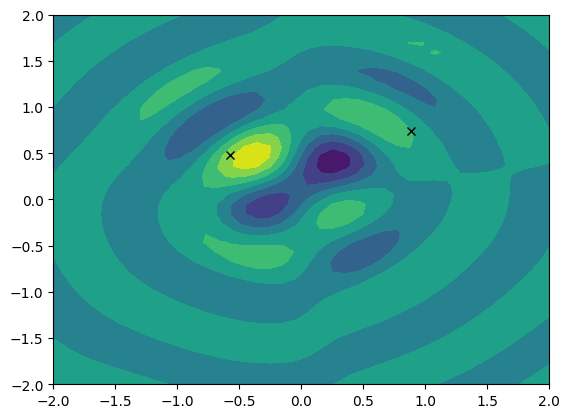

In [382]:
plt.contourf(grid[:,0].reshape(ngrid,ngrid), grid[:,1].reshape(ngrid,ngrid), 
             rbf.reshape(ngrid,ngrid))
plt.plot(h2o_frames[iframe].positions[1:,0], h2o_frames[iframe].positions[1:,1], 'kx')

In [383]:
hypers = {
    "cutoff": 4,
    "max_radial": 4,
    "max_angular": 2,
    "atomic_gaussian_width": 0.5,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "center_atom_weight": 1.0
}

basis_functions = rascaline.utils.SphericalBesselBasis(hypers["cutoff"], hypers["max_radial"], hypers["max_angular"])

basis_integrals = rascaline.utils.SoapSpliner(
    cutoff=hypers["cutoff"],
    max_radial=hypers["max_radial"],
    max_angular=hypers["max_angular"],
    basis=basis_functions,
    density=rascaline.utils.DeltaDensity()
).compute()

hypers["radial_basis"] = basis_integrals

In [291]:
soap_calculator = rascaline.SoapPowerSpectrum(**hypers)
rhoi_oh = soap_calculator.compute(h2o_frames, 
                    selected_keys=mt.Labels(["species_center", "species_neighbor_1", "species_neighbor_2"],
                                           np.array([[8,1,1]]))
                                   )

In [239]:
rho2i_sbb

TensorMap with 1 blocks
keys: species_center  species_neighbor_1  species_neighbor_2
            8                 1                   1

In [231]:
rgrid = np.linspace(0, hypers["cutoff"], 100)
Rnl = { (n,l) : basis_functions.compute(n=n, ell=l, integrand_positions=rgrid) 
        for n in range(0,hypers["max_radial"]-1) for l in range(0, hypers["max_angular"]) }

In [274]:
bip = np.array([ [ bp['position'], bp['values']['data'][0] ] for bp in 
basis_integrals['TabulatedRadialIntegral']['points'] ] )

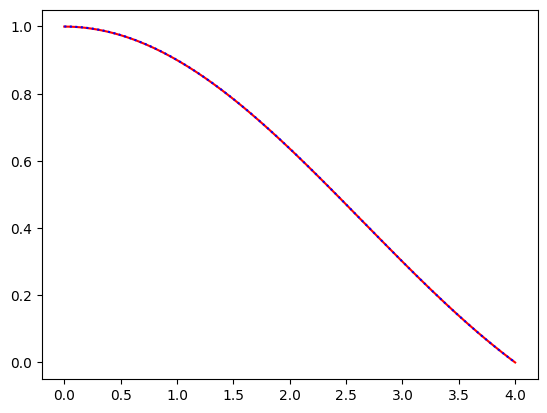

In [284]:
plt.plot(bip[:,0], bip[:,1]*1.8, 'r')
plt.plot(rgrid, Rnl[(0,0)], 'b:')

In [242]:
rho2i_sbb.block(0).properties[0]

LabelsEntry(l=0, n1=0, n2=0)

In [241]:
rho2i_sbb.block(0).values[0]

ExternalCpuArray([0.08029865, 0.11674579, 0.09505567, 0.03764044,
                  0.11674579, 0.16973609, 0.13820094, 0.05472523,
                  0.09505567, 0.13820094, 0.11252468, 0.04455787,
                  0.03764044, 0.05472523, 0.04455787, 0.01764416,
                  0.0266012 , 0.05787545, 0.07197882, 0.059445  ,
                  0.05787545, 0.12666862, 0.15943289, 0.1350702 ,
                  0.07197882, 0.15943289, 0.20543712, 0.18248262,
                  0.059445  , 0.1350702 , 0.18248262, 0.17668838,
                  0.00549635, 0.01520298, 0.02290275, 0.02171291,
                  0.01520298, 0.04244374, 0.06516275, 0.06460314,
                  0.02290275, 0.06516275, 0.10382035, 0.11149491,
                  0.02171291, 0.06460314, 0.11149491, 0.13845422])

In [245]:
[np.sqrt(np.sum(h2o_frames[0].positions**2,axis=1))]

[array([0. , 0.7, 1.2])]

In [255]:
bfval= np.array([
    basis_functions.compute(n=0, ell=0, 
                        integrand_positions=np.sqrt(np.sum(h2o_frames[i].positions**2,axis=1)) )
    for i in range(0,121,11) ])

In [286]:
manual = [ (bfval[i,1]+bfval[i,2])**2 for i in range(len(bfval))] 

In [261]:
ref = rho2i_sbb.block(0).values[::11,0]

In [287]:
manual/ref

array([40.74366543, 40.74366543, 40.74366543, 40.74366543, 40.74366543,
       40.74366543, 40.74366543, 40.74366543, 40.74366543, 40.74366543,
       40.74366543])

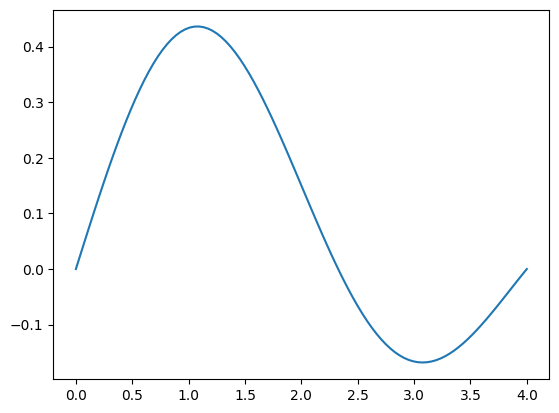

In [234]:

plt.plot(rgrid, Rnl[(1,1)])

# Equivariant features